In [1]:
def addThree(input_nr):
    '''returns the input integer plus 3, used to verify unit test'''
    return input_nr + 3

In [2]:
###############################################################################
# IMPORT STATEMENTS ###########################################################
###############################################################################
import os
import numpy as np
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice_interface
from tudatpy.kernel.simulation import environment_setup
from tudatpy.kernel.simulation import propagation_setup
from tudatpy.kernel.astro import conversion

# Set path to latex image folders for project 1
latex_image_path = 'latex/project1/Images/'

# Load spice kernels.
spice_interface.load_standard_kernels()

# Set simulation start and end epochs.
simulation_start_epoch = 0.0
simulation_end_epoch = constants.JULIAN_DAY

###########################################################################
# CREATE ENVIRONMENT ######################################################
###########################################################################

# Create default body settings for selected celestial bodies
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as 
# global frame origin and orientation. This environment will only be valid 
# in the indicated time range 
# [simulation_start_epoch --- simulation_end_epoch]
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    simulation_start_epoch,
    simulation_end_epoch,
    "Earth","J2000")

# Create system of selected celestial bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

###########################################################################
# CREATE VEHICLE ##########################################################
###########################################################################

# Create vehicle objects.
bodies.create_empty_body( "Delfi-C3" )
bodies.get_body( "Delfi-C3").set_constant_mass(400.0)

# Create aerodynamic coefficient interface settings, and add to vehicle
reference_area = 4.0
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area,[drag_coefficient,0,0]
)
environment_setup.add_aerodynamic_coefficient_interface(
            bodies, "Delfi-C3", aero_coefficient_settings )

# Create radiation pressure settings, and add to vehicle
reference_area_radiation = 4.0
radiation_pressure_coefficient = 1.2
occulting_bodies = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
environment_setup.add_radiation_pressure_interface(
            bodies, "Delfi-C3", radiation_pressure_settings )

###########################################################################
# CREATE ACCELERATIONS ####################################################
###########################################################################

# Define bodies that are propagated.
bodies_to_propagate = ["Delfi-C3"]

# Define central bodies.
central_bodies = ["Earth"]

# Define accelerations acting on Delfi-C3 by Sun and Earth.
accelerations_settings_delfi_c3 = dict(
    Sun=
    [
        propagation_setup.acceleration.cannonball_radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=
    [
        propagation_setup.acceleration.spherical_harmonic_gravity(5, 5),
        propagation_setup.acceleration.aerodynamic()
    ])

# Define point mass accelerations acting on Delfi-C3 by all other bodies.
for other in set(bodies_to_create).difference({"Sun", "Earth"}):
    accelerations_settings_delfi_c3[other] = [
        propagation_setup.acceleration.point_mass_gravity()]

# Create global accelerations settings dictionary.
acceleration_settings = {"Delfi-C3": accelerations_settings_delfi_c3}

# Create acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

###########################################################################
# CREATE PROPAGATION SETTINGS #############################################
###########################################################################

# Set initial conditions for the Asterix satellite that will be
# propagated in this simulation. The initial conditions are given in
# Keplerian elements and later on converted to Cartesian elements.
earth_gravitational_parameter = bodies.get_body( "Earth" ).gravitational_parameter
initial_state = conversion.keplerian_to_cartesian(
    gravitational_parameter=earth_gravitational_parameter,
    semi_major_axis=7500.0E3,
    eccentricity=0.1,
    inclination=np.deg2rad(85.3),
    argument_of_periapsis=np.deg2rad(235.7),
    longitude_of_ascending_node=np.deg2rad(23.4),
    true_anomaly=np.deg2rad(139.87)
)

# Define list of dependent variables to save.
dependent_variables_to_save = [
    propagation_setup.dependent_variable.total_acceleration( "Delfi-C3" ),
    propagation_setup.dependent_variable.keplerian_state( "Delfi-C3", "Earth" ),
    propagation_setup.dependent_variable.latitude( "Delfi-C3", "Earth" ),
    propagation_setup.dependent_variable.longitude( "Delfi-C3", "Earth"),
    propagation_setup.dependent_variable.single_acceleration_norm( 
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Sun" 
    ),
    propagation_setup.dependent_variable.single_acceleration_norm( 
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Moon" 
    ),
    propagation_setup.dependent_variable.single_acceleration_norm( 
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Mars" 
    ),
    propagation_setup.dependent_variable.single_acceleration_norm( 
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Venus" 
    ),
    propagation_setup.dependent_variable.single_acceleration_norm( 
        propagation_setup.acceleration.spherical_harmonic_gravity_type, "Delfi-C3", "Earth" 
    ),
    propagation_setup.dependent_variable.single_acceleration_norm( 
        propagation_setup.acceleration.aerodynamic_type, "Delfi-C3", "Earth" 
    ),
    propagation_setup.dependent_variable.single_acceleration_norm( 
        propagation_setup.acceleration.cannonball_radiation_pressure_type, "Delfi-C3", "Sun" 
    )
    ]


# Create propagation settings.
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_end_epoch,
    output_variables = dependent_variables_to_save
)
# Create numerical integrator settings.
fixed_step_size = 10.0
integrator_settings = propagation_setup.integrator.runge_kutta_4(
    simulation_start_epoch,
    fixed_step_size
)

###########################################################################
# PROPAGATE ORBIT #########################################################
###########################################################################

# Create simulation object and propagate dynamics.
dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
    bodies, integrator_settings, propagator_settings)
states = dynamics_simulator.state_history
dependent_variables = dynamics_simulator.dependent_variable_history

###########################################################################
# PRINT INITIAL AND FINAL STATES ##########################################
###########################################################################

print(
    f"""
Single Earth-Orbiting Satellite Example.
The initial position vector of Delfi-C3 is [km]: \n{
    states[simulation_start_epoch][:3] / 1E3}
The initial velocity vector of Delfi-C3 is [km/s]: \n{
    states[simulation_start_epoch][3:] / 1E3}
After {simulation_end_epoch} seconds the position vector of Delfi-C3 is [km]: \n{
    states[simulation_end_epoch][:3] / 1E3}
And the velocity vector of Delfi-C3 is [km/s]: \n{
    states[simulation_end_epoch][3:] / 1E3}
    """
)



Single Earth-Orbiting Satellite Example.
The initial position vector of Delfi-C3 is [km]: 
[7037.48400133 3238.05901792 2150.7241875 ]
The initial velocity vector of Delfi-C3 is [km/s]: 
[-1.46565763 -0.04095839  6.62279761]
After 86400.0 seconds the position vector of Delfi-C3 is [km]: 
[-4602.79426676 -1421.16740978  5883.69740624]
And the velocity vector of Delfi-C3 is [km/s]: 
[-4.53846052 -2.36988263 -5.04163195]
    


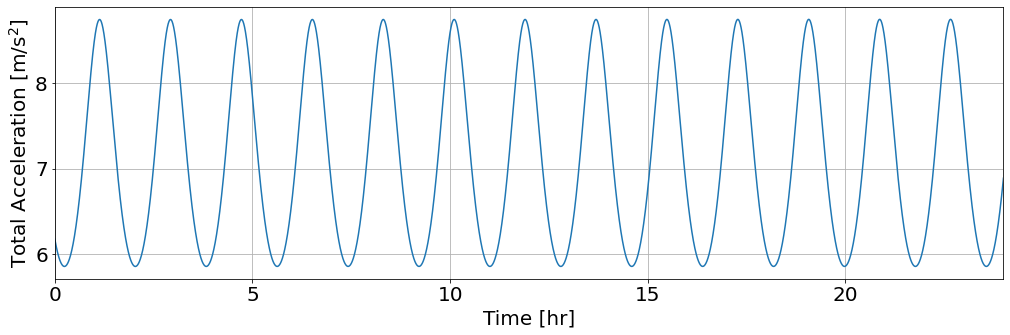

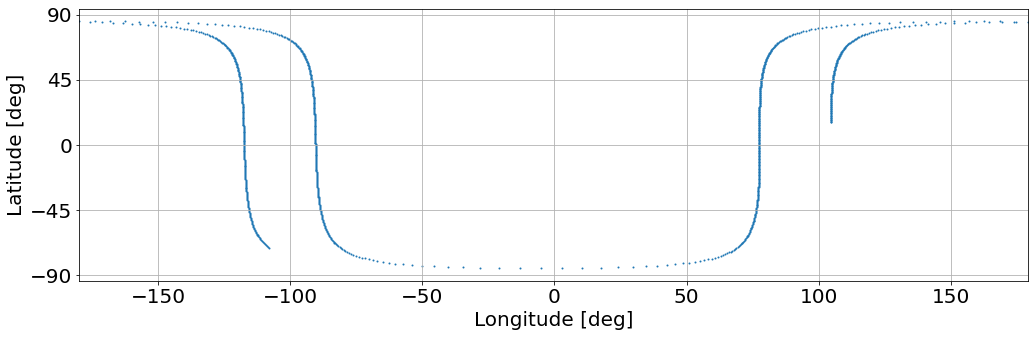

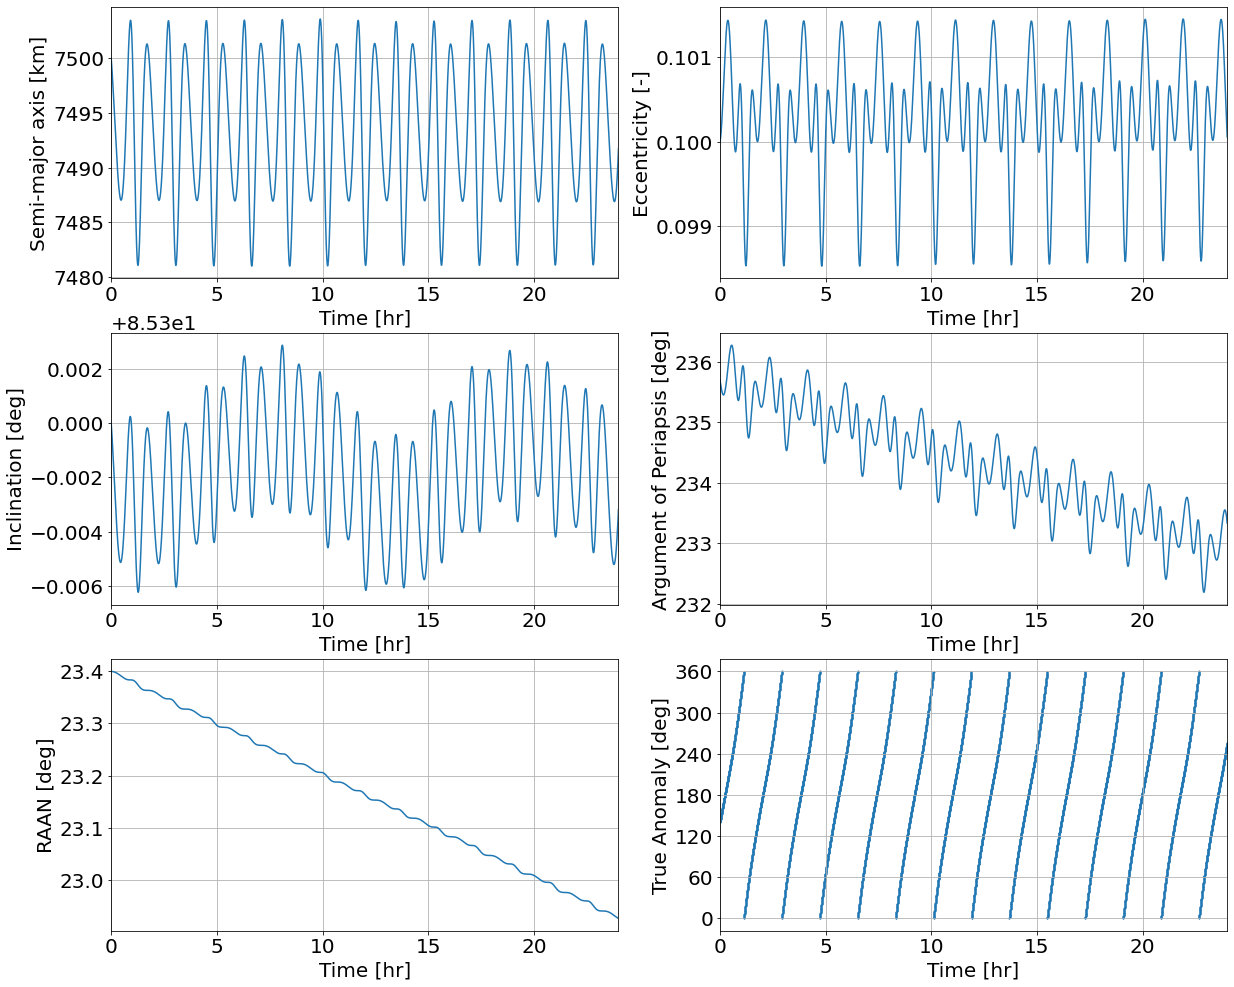

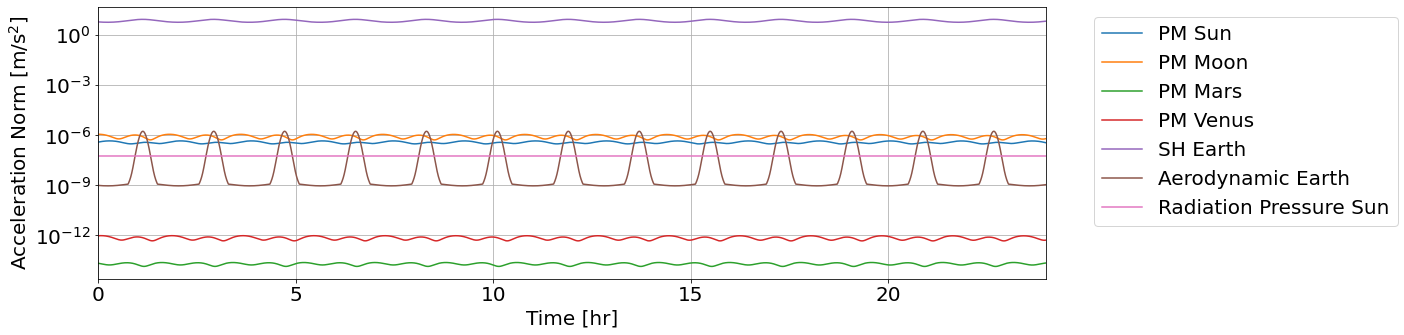

In [3]:
import os
from matplotlib import pyplot as plt

time = dependent_variables.keys()
dependent_variable_list = np.vstack(list(dependent_variables.values()))
font_size = 20

plt.rcParams.update({'font.size': font_size}) 

# dependent variables
# 0-2: total acceleration
# 3-8: Keplerian state
# 9: latitude
# 10: longitude
# 11: Acceleration Norm PM Sun
# 12: Acceleration Norm PM Moon
# 13: Acceleration Norm PM Mars
# 14: Acceleration Norm PM Venus
# 15: Acceleration Norm SH Earth

total_acceleration = np.sqrt( dependent_variable_list[:,0] ** 2 + dependent_variable_list[:,1] ** 2 + dependent_variable_list[:,2] ** 2 )

time_hours = [ t / 3600 for t in time]
# Total Acceleration
plt.figure( figsize=(17,5))
plt.grid()
plt.plot( time_hours , total_acceleration )
plt.xlabel('Time [hr]')
plt.ylabel( 'Total Acceleration [m/s$^2$]')
plt.xlim( [min(time_hours), max(time_hours)] )
plt.savefig( fname = f'{latex_image_path}total_acceleration.png', bbox_inches='tight')



# Ground Track
latitude = dependent_variable_list[:,9]
longitude = dependent_variable_list[:,10]

part = int(len(time)/24*3)
latitude = np.rad2deg( latitude[0:part] )
longitude = np.rad2deg( longitude[0:part] )
plt.figure( figsize=(17,5))
plt.grid()
plt.yticks(np.arange(-90, 91, step=45))
plt.scatter( longitude, latitude, s=1 )
plt.xlabel('Longitude [deg]')
plt.ylabel( 'Latitude [deg]')
plt.xlim( [min(longitude), max(longitude)] )
plt.savefig( fname = f'{latex_image_path}ground_track.png', bbox_inches='tight')

# Kepler Elements
kepler_elements = dependent_variable_list[:,3:9]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots( 3, 2, figsize = (20,17) )

# Semi-major Axis
semi_major_axis = [ element/1000 for element in kepler_elements[:,0] ]
ax1.plot( time_hours, semi_major_axis )
ax1.set_ylabel( 'Semi-major axis [km]' )

# Eccentricity
eccentricity = kepler_elements[:,1]
ax2.plot( time_hours, eccentricity )
ax2.set_ylabel( 'Eccentricity [-]' )

# Inclination
inclination = [ np.rad2deg( element ) for element in kepler_elements[:,2] ]
ax3.plot( time_hours, inclination )
ax3.set_ylabel( 'Inclination [deg]')

# Argument of Periapsis
argument_of_periapsis = [ np.rad2deg( element ) for element in kepler_elements[:,3] ]
ax4.plot( time_hours, argument_of_periapsis )
ax4.set_ylabel( 'Argument of Periapsis [deg]' )

# Right Ascension of the Ascending Node
raan = [ np.rad2deg( element ) for element in kepler_elements[:,4] ]
ax5.plot( time_hours, raan )
ax5.set_ylabel( 'RAAN [deg]' )

# True Anomaly
true_anomaly = [ np.rad2deg( element ) for element in kepler_elements[:,5] ]
ax6.scatter( time_hours, true_anomaly, s=1 )
ax6.set_ylabel( 'True Anomaly [deg]' )
ax6.set_yticks(np.arange(0, 361, step=60))

for ax in fig.get_axes():
    ax.set_xlabel('Time [hr]')
    ax.set_xlim( [min(time_hours), max(time_hours)] )
    ax.grid()

plt.savefig( fname = f'{latex_image_path}kepler_elements.png', bbox_inches='tight')
    
plt.figure( figsize=(17,5))

# Point Mass Gravity Acceleration Sun
acceleration_norm_pm_sun = dependent_variable_list[:, 11]
plt.plot( time_hours, acceleration_norm_pm_sun, label='PM Sun')

# Point Mass Gravity Acceleration Moon
acceleration_norm_pm_moon = dependent_variable_list[:, 12]
plt.plot( time_hours, acceleration_norm_pm_moon, label='PM Moon')

# Point Mass Gravity Acceleration Mars
acceleration_norm_pm_mars = dependent_variable_list[:, 13]
plt.plot( time_hours, acceleration_norm_pm_mars, label='PM Mars')

# Point Mass Gravity Acceleration Venus
acceleration_norm_pm_venus = dependent_variable_list[:, 14]
plt.plot( time_hours, acceleration_norm_pm_venus, label='PM Venus')

# Spherical Harmonic Gravity Acceleration Earth
acceleration_norm_sh_earth = dependent_variable_list[:, 15]
plt.plot( time_hours, acceleration_norm_sh_earth, label='SH Earth')

# Aerodynamic Acceleration Earth
acceleration_norm_aero_earth = dependent_variable_list[:, 16]
plt.plot( time_hours, acceleration_norm_aero_earth, label='Aerodynamic Earth')

# Cannonball Radiation Pressure Acceleration Sun
acceleration_norm_rp_sun = dependent_variable_list[:, 17]
plt.plot( time_hours, acceleration_norm_rp_sun, label='Radiation Pressure Sun')

plt.grid()
plt.legend( bbox_to_anchor=(1.04,1) )
plt.xlim( [min(time_hours), max(time_hours)])
plt.yscale('log')
plt.xlabel( 'Time [hr]' )
plt.ylabel( 'Acceleration Norm [m/s$^2$]' )

plt.savefig( fname = f'{latex_image_path}acceleration_norms.png', bbox_inches='tight')
#plt.savefig('acceleration_norms.png', bbox_inches='tight')
